# Spark

## MLIB Lab 1

### Adrian Garcia and Pol Medina
#### Data Management | AI Degree - UAB

<div class="alert alert-block alert-warning">
            <b>In the first cells we are following the tutorial. If you want to directly jump into the exercises:</b>
</div>

> [For question 1 click here.](#Question-1:)

> [For question 2 click here.](#Question-2:)

> [For question 3 click here.](#Question-3:)

> [For question 4 click here.](#Question-4:)

> [For question 5 click here.](#Question-5:)

In [2]:
import findspark
findspark.init("/home/alumno/Escritorio/spark/spark-3.2.2-bin-hadoop2.7")

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

conf=SparkConf().setAppName("intro").setMaster("local")
sc = SparkContext(conf=conf)
spark=SparkSession(sc)

# **1. Spark ML introduction**

In [3]:
movies_csv="/home/alumno/Descargas/ml-latest-small/movies.csv"
ratings_csv="/home/alumno/Descargas/ml-latest-small/ratings.csv"

moviesDF=spark.read.option("header",True).csv(movies_csv, inferSchema=True)
ratingsDF=spark.read.option("header",True).csv(ratings_csv, inferSchema=True)

moviesDF.printSchema()
ratingsDF.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



# **2. Join input DataFrames**

In [4]:
features = ratingsDF.join(moviesDF, ["movieId"], "left")

features.summary().show()

+-------+----------------+------------------+------------------+--------------------+--------------------+------------------+
|summary|         movieId|            userId|            rating|           timestamp|               title|            genres|
+-------+----------------+------------------+------------------+--------------------+--------------------+------------------+
|  count|          100836|            100836|            100836|              100836|              100836|            100836|
|   mean|19435.2957177992|326.12756356856676| 3.501556983616962|1.2059460873684695E9|                null|              null|
| stddev|35530.9871987003| 182.6184914635004|1.0425292390606342|2.1626103599513078E8|                null|              null|
|    min|               1|                 1|               0.5|           828124615|"11'09""01 - Sept...|(no genres listed)|
|    25%|            1199|               177|               3.0|          1018535155|                null|            

In [5]:
features.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- userId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [6]:
features.show(10, truncate=False)

+-------+------+------+---------+---------------------------+-------------------------------------------+
|movieId|userId|rating|timestamp|title                      |genres                                     |
+-------+------+------+---------+---------------------------+-------------------------------------------+
|1      |1     |4.0   |964982703|Toy Story (1995)           |Adventure|Animation|Children|Comedy|Fantasy|
|3      |1     |4.0   |964981247|Grumpier Old Men (1995)    |Comedy|Romance                             |
|6      |1     |4.0   |964982224|Heat (1995)                |Action|Crime|Thriller                      |
|47     |1     |5.0   |964983815|Seven (a.k.a. Se7en) (1995)|Mystery|Thriller                           |
|50     |1     |5.0   |964982931|Usual Suspects, The (1995) |Crime|Mystery|Thriller                     |
|70     |1     |3.0   |964982400|From Dusk Till Dawn (1996) |Action|Comedy|Horror|Thriller              |
|101    |1     |5.0   |964980868|Bottle Rocket

---

### **Question 1:**

***Which one of the following options is correct regarding the requirements of ML algorithms in MLlib?***

---

**Answer:** C: movieId, userId, rating, and timestamp can all be used as features because their data type is numeric

**Reasoning:** The answer C is correct because all the available data is of the type numeric, which is an intrinsic requirement from MLlib: numeric data.

## **3. Preparation of input data for model building and testing**

In [7]:
(trainDF, tempDF) = features.randomSplit([0.8, 0.2], seed=1)

___

### **Question 2:**

***Draw the result of join operations left-semi and left-anti in a simple schema with two sets (red and yellow) with some elements in common:***

---

**Self Notes:**

Left-semi: El DF de la izquierda se compara con el de la derecha con la variable determinada. Todas las IDs que coincidan, se guardaran sus datos provenientes del DF izquierdo.

Leff- anti: Cogere todos los datos de todas las IDs de mi DF de la izquierda siempre que no coincidan con ninguna ID de la derecha.

In [8]:
validationDF = (tempDF.join(trainDF, ["userId"], "left_semi")
                      .join(trainDF, ["movieId"], "left_semi"))

nonMatch = tempDF.join(validationDF, ["movieId", "userId"], "left_anti")

trainDF = trainDF.union(nonMatch)

validationDF.printSchema()

print(features.count())
print(trainDF.count())
print(validationDF.count())

root
 |-- movieId: integer (nullable = true)
 |-- userId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)

100836
81303
19533


In [9]:
trainDF.select("userId","movieId","rating").show(5)

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
|     5|      1|   4.0|
|     7|      1|   4.5|
|    15|      1|   2.5|
|    18|      1|   3.5|
+------+-------+------+
only showing top 5 rows



Text(0.5, 0, 'Rating')

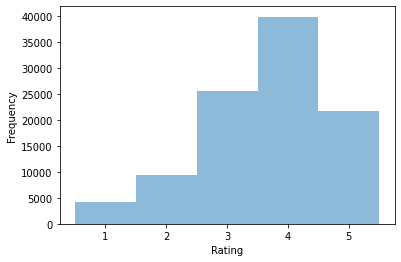

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

ratingPandas=ratingsDF.select("rating").collect()


ratingList=[ratingPandas[i][0] for i in range(len(ratingPandas))]
plt.hist(ratingList, bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], alpha=0.5, histtype='stepfilled')
plt.ylabel('Frequency')
plt.xlabel('Rating')

# **4. Recommendation model: ALS matrix factorization model**

**Notes:**

*Collaborative filtering: This technique assumes that if user A has the same opinion as user B on an issue, A is more likely to have B's (similar) opinion on another different issue.*

In [11]:
from pyspark.ml.recommendation import ALS

als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating")

model = als.fit(trainDF) # create the transformer and train it 

predDF = model.transform(validationDF) # transform (predict) the val set
predDF.show(5, truncate=False)

+-------+------+------+----------+--------------------------+-------------------------------------------+----------+
|movieId|userId|rating|timestamp |title                     |genres                                     |prediction|
+-------+------+------+----------+--------------------------+-------------------------------------------+----------+
|1      |471   |5.0   |1496671820|Toy Story (1995)          |Adventure|Animation|Children|Comedy|Fantasy|3.7205272 |
|296    |463   |4.0   |1145460490|Pulp Fiction (1994)       |Comedy|Crime|Drama|Thriller                |4.0353074 |
|296    |471   |4.0   |1496671827|Pulp Fiction (1994)       |Comedy|Crime|Drama|Thriller                |3.9463596 |
|1092   |463   |3.0   |1145460035|Basic Instinct (1992)     |Crime|Mystery|Thriller                     |3.0486786 |
|1197   |148   |3.0   |1482548478|Princess Bride, The (1987)|Action|Adventure|Comedy|Fantasy|Romance    |3.6448712 |
+-------+------+------+----------+--------------------------+---

In [12]:
from pyspark.ml.evaluation import RegressionEvaluator

regEvaluator = RegressionEvaluator(predictionCol="prediction", labelCol="rating")
r2 = regEvaluator.setMetricName("r2").evaluate(predDF)

r2

0.2678298836967642

**Notes:**

*An r2 value of 0.27 means that our model does not give very accurate results, since a regression evaluator should give values close to 1 for good predictions.*

# **5. Generating item recommendations for users**

In [13]:
usersRec = model.recommendForAllUsers(5)

usersRec.printSchema()

usersRec.show(5, truncate=False)

/home/alumno/Escritorio/spark/spark-3.2.2-bin-hadoop2.7/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


root
 |-- userId: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- movieId: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)

+------+------------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                       |
+------+------------------------------------------------------------------------------------------------------+
|1     |[{33649, 5.980285}, {5485, 5.8209505}, {1223, 5.6481094}, {93988, 5.6355076}, {177593, 5.6233187}]    |
|2     |[{130518, 4.9719405}, {131724, 4.9047675}, {78836, 4.7301617}, {7071, 4.6919365}, {117531, 4.6919365}]|
|3     |[{6835, 4.926823}, {5746, 4.926823}, {5181, 4.9250064}, {7991, 4.8482413}, {70946, 4.826568}]         |
|4     |[{971, 5.46433}, {2070, 5.277354}, {7700, 5.071831}, {1212, 5.0274377}, {3706, 5.01

In [14]:
from pyspark.sql.functions import col, explode, lit

user = usersRec.first().userId

movieRec1 = usersRec.filter(f"userId == {user}").withColumn("recs",explode("recommendations"))

movieRec2 = movieRec1.select("userId", col("recs").movieId.alias("movieId"),
                                       col("recs").rating.alias("rating"))

movieRec = movieRec2.join(moviesDF, "movieId")

m = movieRec.orderBy("rating", descending=True).select("movieId", "title", "rating")

m.show()

+-------+--------------------+---------+
|movieId|               title|   rating|
+-------+--------------------+---------+
| 177593|Three Billboards ...|5.6233187|
|  93988|North & South (2004)|5.6355076|
|   1223|Grand Day Out wit...|5.6481094|
|   5485|      Tadpole (2002)|5.8209505|
|  33649|  Saving Face (2004)| 5.980285|
+-------+--------------------+---------+



---

### **Question 3:**
    
Find the movies not rated by the previous user found. Consider that you can find all the ratings
in ratingsDF. 

- What information can we find there? 

- What does it mean a user has not rated a particular movie?

---

We will have to work with the moviesDF and the ratingsDF dataframe to solve this exercise.

In [15]:
moviesDF.show(5)

ratingsDF.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



We will extract a dataframe with all the information of all the movies that our target user has rated. After, we will remove those movies in a new dataframe, and there will only remain the movies that user hasn't rated yet.

In [16]:
userRatedDF = ratingsDF.filter(f"userId == {user}")
userNotRatedDF = moviesDF.join(userRatedDF, ["movieId"], "left_anti")

If we sum the number of rated movies with the number of not rated movies, the result should be the number of movies in total.

In [17]:
ratedMovies = userRatedDF.count()
notRatedMovies = userNotRatedDF.count()
totalMovies = moviesDF.count()

print(f'There are {totalMovies} movies in total.')
print(f'If we add the number of rated movies ({ratedMovies}) with the number of not rated movies ({notRatedMovies}), the result is of {ratedMovies+notRatedMovies} movies in total.')

There are 9742 movies in total.
If we add the number of rated movies (232) with the number of not rated movies (9510), the result is of 9742 movies in total.


We have calculated that there are 232 films rated by target user and 9510 not rated by it.

- **What information can we find there?** 

> The first thing we see is that there are more unrated than rated movies (as expected).

> So, we can understand that the user still has a huge amount of films to watch, and probably some of them will be of the topic that the target user enjoys. But, as obvious, it is difficult to know which movies will the user like if we have to look for one over that huge catalog. With a recommender we will be able to filter out movies that for sure the user will not like.

- **What does it mean a user has not rated a particular movie?**

> This means that the user has either not seen that film or that the user has seen it but probably, since it didn't either liked it a lot or disliked it a lot, it didn't give any rating. A neutral movie.

----

--- 

### **Question 4:**
    
Show the predicted rating for the unrated movies of question 3. Output should be similar to:

```
+------+-------+----------+
|userId|movieId|prediction|
+------+-------+----------+
| 471  | 1580  | 3.0085273|
| 471  | 2366  | 3.1742785|
+------+-------+----------+
```
---

We will show the predicted raitings only for our target user. However, we have to compute all the predictions for all users anyway.

To do so, we will compute the prediction on all the movies and only retrieve the rated movies that our target user has not rated yet.

In [18]:
usersRec = model.recommendForAllUsers(totalMovies) # compute all recommendations

# Filter by user (retrieve target)
movieRec1 = usersRec.filter(f"userId == {user}").withColumn("recs",explode("recommendations"))

# Select only user, movie and rating to display on dataframe
movieRec2 = movieRec1.select("userId", col("recs").movieId.alias("movieId"),
                                       col("recs").rating.alias("rating"))

# Only retrieve the predictions on movies that the user hasn't rated yet.
movieRec = movieRec2.join(userNotRatedDF, "movieId")

movieRec.show()

+-------+------+---------+--------------------+--------------------+
|movieId|userId|   rating|               title|              genres|
+-------+------+---------+--------------------+--------------------+
|      2|     1|  4.07153|      Jumanji (1995)|Adventure|Childre...|
|      4|     1|2.2209349|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|     1|3.3188996|Father of the Bri...|              Comedy|
|      7|     1|3.7060962|      Sabrina (1995)|      Comedy|Romance|
|      8|     1|2.8624778| Tom and Huck (1995)|  Adventure|Children|
|      9|     1|2.5718884| Sudden Death (1995)|              Action|
|     10|     1|4.2489505|    GoldenEye (1995)|Action|Adventure|...|
|     11|     1| 4.013113|American Presiden...|Comedy|Drama|Romance|
|     12|     1|2.8068328|Dracula: Dead and...|       Comedy|Horror|
|     13|     1|3.4800568|        Balto (1995)|Adventure|Animati...|
|     14|     1| 4.540156|        Nixon (1995)|               Drama|
|     15|     1|3.0264602|Cutthroa

---

### Question 5: 

Show the top 10 movies with best predicted scores sorted by increasing values of ratings.

---

To do so, we will simply use the `.orderBy` method and use the descending attribute. Now we have the same list as before but sorted in ascending order.

In [19]:
# Sort the ratings
m = movieRec.orderBy("rating", descending=False).select("movieId", "title", "rating")

m.show(10)

+-------+--------------------+----------+
|movieId|               title|    rating|
+-------+--------------------+----------+
|  97024|Rust and Bone (De...|0.28545976|
|   3604|        Gypsy (1962)|0.28563365|
|   8772|Spy Who Came in f...|0.29160002|
|  91414|Arthur Christmas ...|0.29160002|
| 144352|   Unforgiven (2013)|0.29160002|
|   6967|Dead of Night (1945)|0.33169904|
|   5105|Don't Look Now (1...|0.33169904|
|   7114|Collector, The (1...|0.33169904|
|   7742|       Baxter (1989)|0.33169904|
|  65350|General Died at D...|0.36139068|
+-------+--------------------+----------+
only showing top 10 rows



We can make sure that we have predicted the unrated movies by checking that the number of predictions must be close to the number of unrated movies. 

We assume that both numbers are not equal because of nan values or problems in the regression calculation or lack of data.

In [20]:
print(f'Unrated movies: {userNotRatedDF.count()}.')
print(f'Predicted movies: {m.count()}.')

Unrated movies: 9510.
Predicted movies: 9492.
